In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV


In [64]:
data = pd.read_excel(r'../data/Data_Train.xlsx')

In [65]:
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [67]:
data.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price'],
      dtype='object')

In [66]:
data.Airline.unique()

array(['IndiGo', 'Air India', 'Jet Airways', 'SpiceJet',
       'Multiple carriers', 'GoAir', 'Vistara', 'Air Asia',
       'Vistara Premium economy', 'Jet Airways Business',
       'Multiple carriers Premium economy', 'Trujet'], dtype=object)

In [68]:
data.Source.unique()

array(['Banglore', 'Kolkata', 'Delhi', 'Chennai', 'Mumbai'], dtype=object)

In [69]:
data.Destination.unique()

array(['New Delhi', 'Banglore', 'Cochin', 'Kolkata', 'Delhi', 'Hyderabad'],
      dtype=object)

In [70]:
data.Total_Stops.unique()

array(['non-stop', '2 stops', '1 stop', '3 stops', nan, '4 stops'],
      dtype=object)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [9]:
data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [10]:
data['Price'] = data.Price.astype(np.int32)

In [11]:
data.Airline.value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1752
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

In [12]:
data.dropna(inplace= True)

In [13]:
data.shape

(10682, 11)

In [14]:
data["Journey_day"] = pd.to_datetime(data["Date_of_Journey"], format="%d/%m/%Y").dt.day
data["Journey_month"] = pd.to_datetime(data["Date_of_Journey"], format="%d/%m/%Y").dt.month

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10682 non-null  object
 1   Date_of_Journey  10682 non-null  object
 2   Source           10682 non-null  object
 3   Destination      10682 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10682 non-null  object
 6   Arrival_Time     10682 non-null  object
 7   Duration         10682 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10682 non-null  object
 10  Price            10682 non-null  int32 
 11  Journey_day      10682 non-null  int64 
 12  Journey_month    10682 non-null  int64 
dtypes: int32(1), int64(2), object(10)
memory usage: 1.1+ MB


In [16]:
data.drop(['Date_of_Journey'],axis = 1,inplace= True)

In [17]:
data["Dep_hour"] = pd.to_datetime(data['Dep_Time']).dt.hour
data["Dep_minute"] = pd.to_datetime(data['Dep_Time']).dt.minute

In [18]:
data.drop(['Dep_Time'],axis = 1,inplace= True)

In [19]:
data["Arrival_hour"] = pd.to_datetime(data['Arrival_Time']).dt.hour
data["Arrival_minute"] = pd.to_datetime(data['Arrival_Time']).dt.minute

In [20]:
data.drop(['Arrival_Time'],axis = 1,inplace= True)

In [21]:
duration = list(data.Duration)

for i in range(len(duration)):
    if len(duration[i].split(" ")) == 2:
        pass
    else:
        if 'h' in duration[i]:
            duration[i] = duration[i]+ " 0m"
        else:
            duration[i] = '0h '+ duration[i]

In [22]:
data['Duration_hour'] = pd.Series(duration).apply(lambda x : int(x.split(" ")[0].replace("h","")))
data['Duration_minute'] = pd.Series(duration).apply(lambda x : int(x.split(" ")[1].replace("m","")))

In [23]:
data.drop(['Duration'],axis = 1,inplace= True)

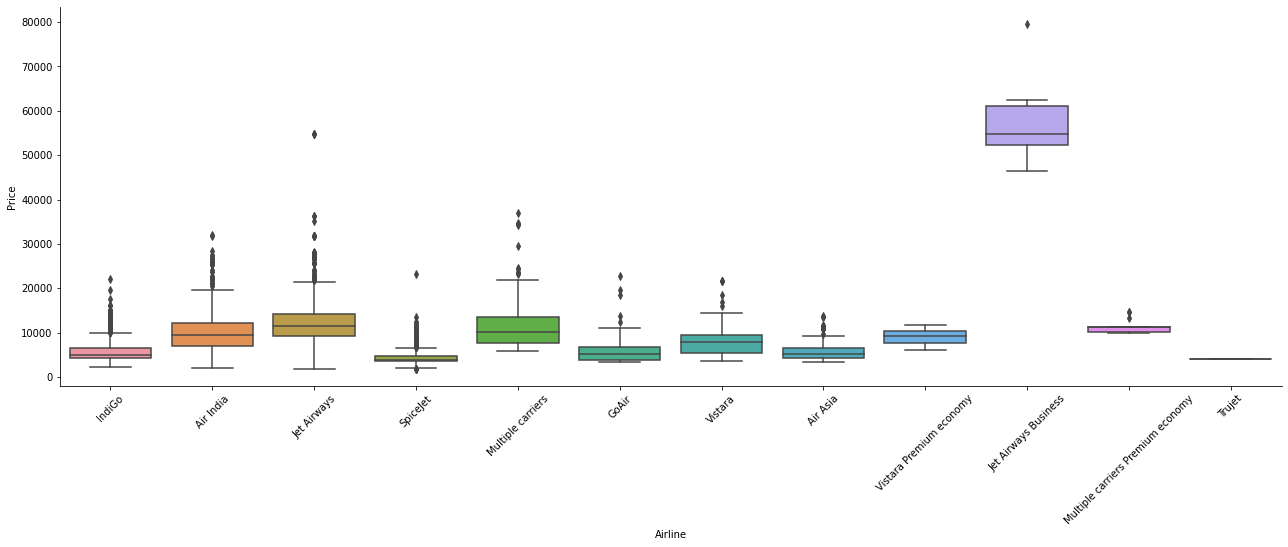

In [24]:

ax = sns.catplot(x = "Airline", y = 'Price', data = data,height=6, aspect = 3, kind = 'box',)
ax.set_xticklabels(rotation = 45)
plt.show()


In [25]:
data.drop(['Route', "Additional_Info"],axis = 1,inplace= True)

In [26]:
data.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_minute,Arrival_hour,Arrival_minute,Duration_hour,Duration_minute
0,IndiGo,Banglore,New Delhi,non-stop,3897,24,3,22,20,1,10,2.0,50.0
1,Air India,Kolkata,Banglore,2 stops,7662,1,5,5,50,13,15,7.0,25.0
2,Jet Airways,Delhi,Cochin,2 stops,13882,9,6,9,25,4,25,19.0,0.0
3,IndiGo,Kolkata,Banglore,1 stop,6218,12,5,18,5,23,30,5.0,25.0
4,IndiGo,Banglore,New Delhi,1 stop,13302,1,3,16,50,21,35,4.0,45.0


In [27]:
data.Total_Stops.value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [28]:
data.columns

Index(['Airline', 'Source', 'Destination', 'Total_Stops', 'Price',
       'Journey_day', 'Journey_month', 'Dep_hour', 'Dep_minute',
       'Arrival_hour', 'Arrival_minute', 'Duration_hour', 'Duration_minute'],
      dtype='object')

In [29]:
X = data.loc[:,['Airline', 'Source', 'Destination', 'Total_Stops',
       'Journey_day', 'Journey_month', 'Dep_hour', 'Dep_minute',
       'Arrival_hour', 'Arrival_minute', 'Duration_hour', 'Duration_minute']]

In [30]:
y = data.Price

In [31]:
X.head()

,Airline,Source,Destination,Total_Stops,Journey_day,Journey_month,Dep_hour,Dep_minute,Arrival_hour,Arrival_minute,Duration_hour,Duration_minute
0,IndiGo,Banglore,New Delhi,non-stop,24,3,22,20,1,10,2.0,50.0
1,Air India,Kolkata,Banglore,2 stops,1,5,5,50,13,15,7.0,25.0
2,Jet Airways,Delhi,Cochin,2 stops,9,6,9,25,4,25,19.0,0.0
3,IndiGo,Kolkata,Banglore,1 stop,12,5,18,5,23,30,5.0,25.0
4,IndiGo,Banglore,New Delhi,1 stop,1,3,16,50,21,35,4.0,45.0


In [32]:
## Encoding Part
order = ['non-stop', '1 stop', '2 stops', '3 stops', '4 stops']
onehotencoder = OneHotEncoder(drop= "first")
ordinalencoder = OrdinalEncoder(categories=[order])
clm = ColumnTransformer(transformers = [('endoer1',onehotencoder,["Airline","Source","Destination"]),
                             ('endoer2',ordinalencoder,["Total_Stops"])], 
                             remainder = 'passthrough')



In [53]:
dump(clm,"../saved_models/clm.joblib")

['../saved_models/clm.joblib']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
X_train = clm.fit_transform(X_train)
model.fit(X_train,y_train)

RandomForestRegressor()

In [35]:
y_pred = model.predict(X_train)

In [36]:
X_test.isnull().sum()

Airline            0
Source             0
Destination        0
Total_Stops        0
Journey_day        0
Journey_month      0
Dep_hour           0
Dep_minute         0
Arrival_hour       0
Arrival_minute     0
Duration_hour      1
Duration_minute    1
dtype: int64

In [37]:
test = pd.concat((X_test,y_test),axis = 1)

In [38]:
test.dropna(axis = 0, inplace=True)

In [39]:
test.isnull().sum()

Airline            0
Source             0
Destination        0
Total_Stops        0
Journey_day        0
Journey_month      0
Dep_hour           0
Dep_minute         0
Arrival_hour       0
Arrival_minute     0
Duration_hour      0
Duration_minute    0
Price              0
dtype: int64

In [40]:
test.columns

Index(['Airline', 'Source', 'Destination', 'Total_Stops', 'Journey_day',
       'Journey_month', 'Dep_hour', 'Dep_minute', 'Arrival_hour',
       'Arrival_minute', 'Duration_hour', 'Duration_minute', 'Price'],
      dtype='object')

In [41]:
X_test = test.loc[:,['Airline', 'Source', 'Destination', 'Total_Stops', 'Journey_day',
       'Journey_month', 'Dep_hour', 'Dep_minute', 'Arrival_hour',
       'Arrival_minute', 'Duration_hour', 'Duration_minute']]
y_test = test.Price

In [42]:
r2_score(y_train,y_pred)

0.9595232311749898

In [43]:
X_test = clm.transform(X_test)
y_test_pred = model.predict(X_test)

In [44]:
r2_score(y_test,y_test_pred)

0.8395552570847278

## Grid search

In [45]:
n_estimators = [int(x) for x in np.linspace(100,1200,12)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5,30,6)]
min_samples_split = [2,5,10,15,100]
min_samples_leaf = [1,2,5,10]

In [46]:
grid = {'n_estimators': n_estimators,
"max_features":max_features,
"max_depth":max_depth,
"min_samples_split":min_samples_split,
"min_samples_leaf":min_samples_leaf}

In [47]:
grid_search = RandomizedSearchCV(model, param_distributions= grid,n_iter= 10, scoring= mean_squared_error,n_jobs= -1)

In [48]:
grid_search.fit(X_train,y_train)

e:\Projects\Flight_Fare\flightfareenv\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


RandomizedSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   scoring=<function mean_squared_error at 0x0000022AEBEDE4D0>)

In [49]:
grid_search.best_params_

{'n_estimators': 100,
 'min_samples_split': 10,
 'min_samples_leaf': 10,
 'max_features': 'auto',
 'max_depth': 10}

In [50]:
prediction = grid_search.predict(X_test)

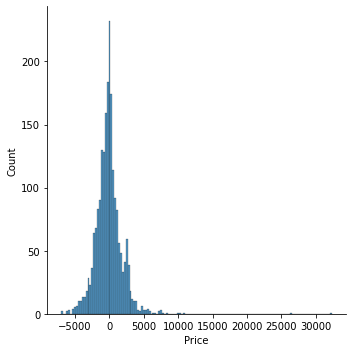

In [51]:

sns.displot(y_test-prediction)
plt.show()

In [52]:
dump(model,'flight_fare.joblib')

['flight_fare.joblib']